In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold

In [2]:
train_df = pd.read_csv("dataset/train_processed_last_version.csv")
test_df = pd.read_csv("dataset/test_processed_last_version.csv")

In [3]:
X_train = train_df.drop("label", axis=1)
y_train = train_df["label"]
X_test  = test_df.drop("label", axis=1)
y_test  = test_df["label"]

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models



def create_wide_deep_model(input_dim, num_classes=4):

    inputs = layers.Input(shape=(input_dim,))


    wide = layers.Dense(num_classes)(inputs)


    deep = layers.Dense(128, activation='relu')(inputs)
    deep = layers.Dropout(0.4)(deep)

    deep = layers.Dense(64, activation='relu')(deep)
    deep = layers.Dropout(0.3)(deep)

    deep = layers.Dense(num_classes)(deep)


    combined = layers.Add()([wide, deep])
    outputs = layers.Activation('softmax')(combined)

    model = models.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model



best_accuracy = 0.0
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
cv_scores = []

for train_index, val_index in kfold.split(X_train):

    print(f"\n------ Fold {fold_no} ------")

    X_tr_raw, X_val_raw = X_train.iloc[train_index], X_train.iloc[val_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

    # Imputer
    imputer = SimpleImputer(strategy="median")
    X_tr = imputer.fit_transform(X_tr_raw)
    X_val = imputer.transform(X_val_raw)

    # SMOTE
    smote = SMOTE(random_state=42)
    X_tr_res, y_tr_res = smote.fit_resample(X_tr, y_tr)

    # Model
    model = create_wide_deep_model(X_train.shape[1])

    # Train
    history = model.fit(
        X_tr_res, y_tr_res,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=512,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor="val_loss",
                patience=10,
                restore_best_weights=True
            )
        ],
        verbose=1
    )

    scores = model.evaluate(X_val, y_val, verbose=0)
    cv_scores.append(scores[1])

    if scores[1] > best_accuracy:
        best_accuracy = scores[1]
        best_model = model
        model.save("best_model_WideDeep.h5")
        print(f"--> En iyi model fold {fold_no} olarak kaydedildi!")

    print(f"Fold {fold_no} Accuracy: {scores[1]:.4f}")
    fold_no += 1


print("\nK-Fold Ortalama Accuracy:", np.mean(cv_scores))
print("En iyi fold accuracy:", best_accuracy)



------ Fold 1 ------
Epoch 1/50
2052/2052 [==============================] - 9s 3ms/step - loss: 2.1011 - accuracy: 0.6696 - val_loss: 0.4450 - val_accuracy: 0.8537
Epoch 2/50
2052/2052 [==============================] - 7s 3ms/step - loss: 0.4018 - accuracy: 0.8614 - val_loss: 0.2381 - val_accuracy: 0.9212
Epoch 3/50
2052/2052 [==============================] - 7s 3ms/step - loss: 0.3198 - accuracy: 0.8903 - val_loss: 0.2094 - val_accuracy: 0.9252
Epoch 4/50
2052/2052 [==============================] - 7s 3ms/step - loss: 0.2845 - accuracy: 0.9017 - val_loss: 0.1886 - val_accuracy: 0.9326
Epoch 5/50
2052/2052 [==============================] - 7s 3ms/step - loss: 0.2627 - accuracy: 0.9093 - val_loss: 0.1804 - val_accuracy: 0.9357
Epoch 6/50
2052/2052 [==============================] - 7s 3ms/step - loss: 0.2483 - accuracy: 0.9143 - val_loss: 0.1704 - val_accuracy: 0.9378
Epoch 7/50
2052/2052 [==============================] - 7s 3ms/step - loss: 0.2381 - accuracy: 0.9181 - val_loss: 

In [ ]:
from sklearn.metrics import f1_score

final_imputer = imputer


X_test_imputed = final_imputer.transform(X_test)
y_pred_probs = model.predict(X_test_imputed)
y_pred = np.argmax(y_pred_probs, axis=1)

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
test_f1 = f1_score(y_test, y_pred, average="weighted")

print("\nTest Accuracy:", test_acc)
print("Test F1 Score:", test_f1)

3921/3921 [==============================] - 5s 1ms/step

Test Accuracy: 0.9601498246192932
Test F1 Score: 0.9609561599405593


In [6]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

y_test_bin = label_binarize(y_test, classes=[0,1,2,3])

test_auc = roc_auc_score(
    y_test_bin,
    y_pred_probs,
    average="weighted",
    multi_class="ovr"
)

print("Test AUC:", test_auc)

Test AUC: 0.9983451431422102


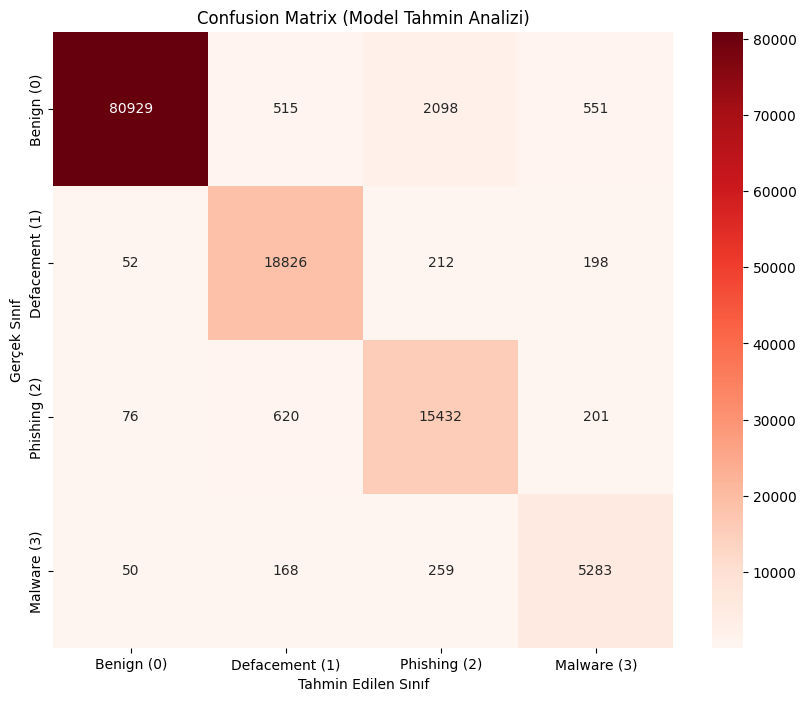


--- Sınıflandırma Raporu ---
                precision    recall  f1-score   support

    Benign (0)       1.00      0.96      0.98     84093
Defacement (1)       0.94      0.98      0.96     19288
  Phishing (2)       0.86      0.95      0.90     16329
   Malware (3)       0.85      0.92      0.88      5760

      accuracy                           0.96    125470
     macro avg       0.91      0.95      0.93    125470
  weighted avg       0.96      0.96      0.96    125470



In [7]:
from sklearn.metrics import confusion_matrix, classification_report

class_names = ['Benign (0)', 'Defacement (1)', 'Phishing (2)', 'Malware (3)']

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix (Model Tahmin Analizi)')
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.show()


print("\n--- Sınıflandırma Raporu ---")
print(classification_report(y_test, y_pred, target_names=class_names))

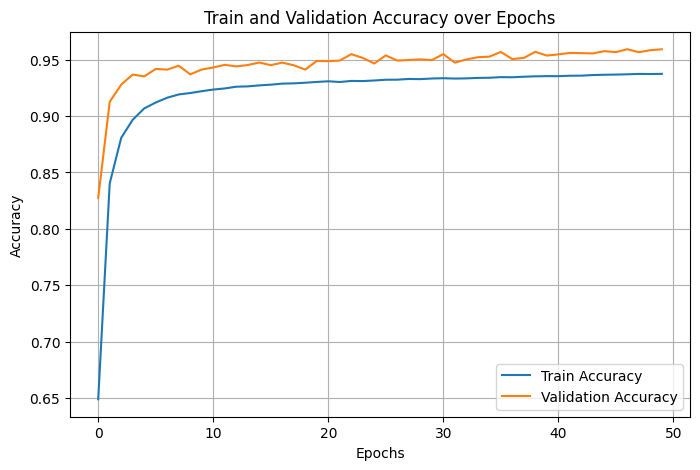

In [8]:
plt.figure(figsize=(8, 5))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy over Epochs")
plt.legend()
plt.grid(True)
plt.show()

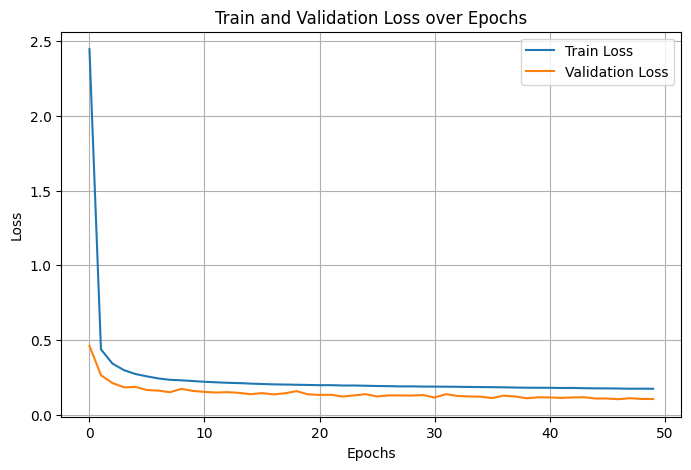

In [9]:
plt.figure(figsize=(8, 5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()